In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')

In [12]:
initial_df = pd.read_csv('data/train.csv')
initial_df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363


# convert to daily data

In [73]:
initial_df.isnull().sum()

Datetime                            0
ActivePower                         0
AmbientTemperatue                 896
BearingShaftTemperature         26684
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26682
GearboxOilTemperature           26670
GeneratorRPM                    26674
GeneratorWinding1Temperature    26656
GeneratorWinding2Temperature    26649
HubTemperature                  26792
MainBoxTemperature              26704
NacellePosition                 20424
ReactivePower                      42
RotorRPM                        26680
TurbineStatus                   26466
WindDirection                   20424
WindSpeed                         308
dtype: int64

In [13]:
initial_df['Datetime'] = pd.to_datetime(initial_df['Datetime'])

In [14]:
daily_mean = initial_df.groupby(pd.Grouper(key='Datetime', freq='D')).mean()

In [15]:
daily_mean.head(3)

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225


In [16]:
len(daily_mean)

805

In [17]:
df = pd.DataFrame(index=daily_mean.index)

df['ActivePower'] = daily_mean['ActivePower']

In [18]:
df.head()

,ActivePower
Datetime,
2018-01-01 00:00:00+00:00,366.223561
2018-01-02 00:00:00+00:00,462.550740
2018-01-03 00:00:00+00:00,454.417752
2018-01-04 00:00:00+00:00,369.952190
2018-01-05 00:00:00+00:00,319.446595


<Axes: xlabel='Datetime'>

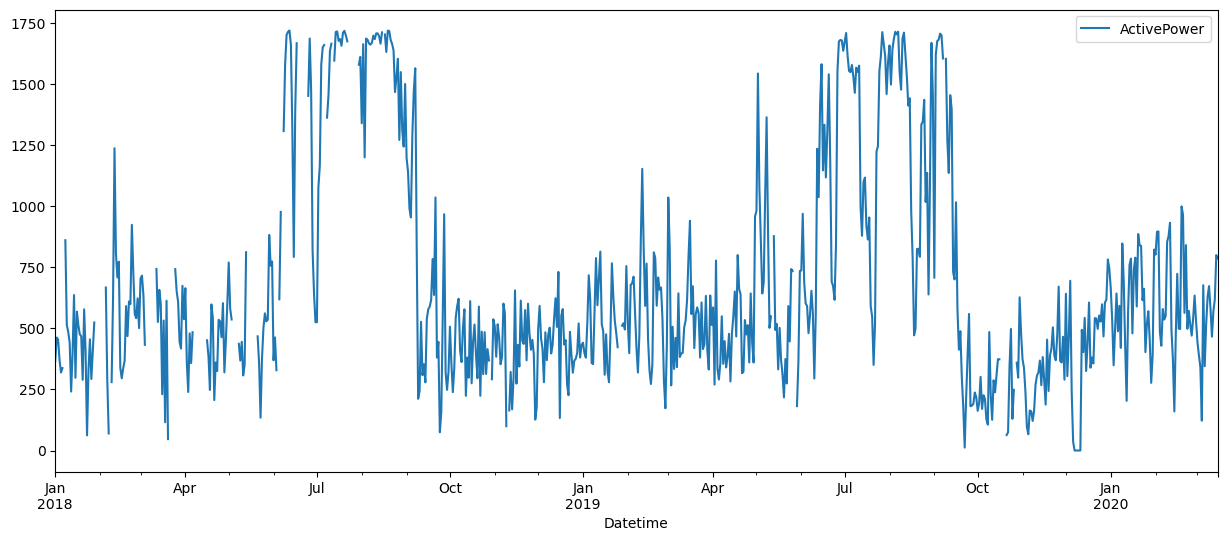

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(ax=ax)


In [49]:
df.isnull().sum()

ActivePower    71
dtype: int64

In [50]:
# fill nan with mean
y = df['ActivePower']
mean = y.mean()
df['ActivePower'] = df['ActivePower'].fillna(mean)

In [51]:
df.isnull().sum()

ActivePower    0
dtype: int64

In [52]:
(df['ActivePower'] == 0).sum(),(df['ActivePower'] < 0).sum()

(4, 0)

In [53]:
df['ActivePower'] = df['ActivePower'].replace(0, 0.1)

In [54]:
(df['ActivePower'] <= 0).any()

False

In [55]:
# split data
train = df[:-15]
test = df[-15:]

In [56]:
test.head()

,ActivePower
Datetime,
2020-03-01 00:00:00+00:00,443.058496
2020-03-02 00:00:00+00:00,390.027361
2020-03-03 00:00:00+00:00,341.133560
2020-03-04 00:00:00+00:00,122.348957
2020-03-05 00:00:00+00:00,676.893151


In [57]:
(train <= 0).any()

ActivePower    False
dtype: bool

<Axes: xlabel='Datetime'>

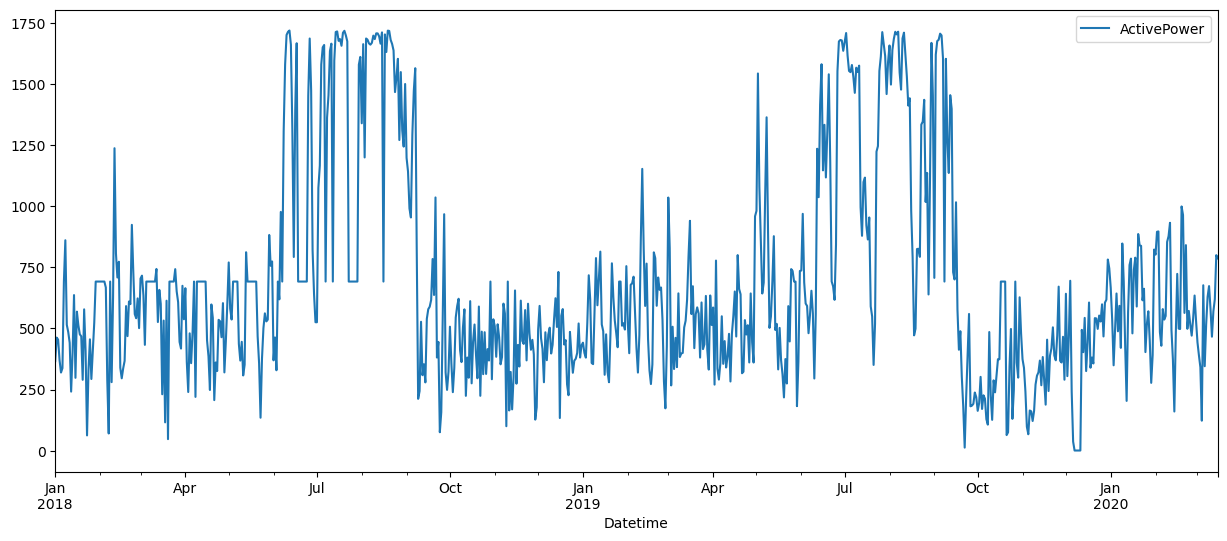

In [58]:
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(ax=ax)

# ETS

In [59]:
# Holt-Winters ETS

model_1 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=365, damped_trend=False).fit()
model_2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=365, damped_trend=False).fit()
model_3 = ExponentialSmoothing(train, seasonal="add", seasonal_periods=365, damped_trend=False).fit()
model_4 = ExponentialSmoothing(train, seasonal="mul", seasonal_periods=365, damped_trend=False).fit()
# damped_trend=True must has trend parameter
# when seasonal = 'mul', values must > 0

In [60]:
pred_1 = pd.DataFrame(model_1.forecast(len(test)))
pred_2 = pd.DataFrame(model_2.forecast(len(test)))
pred_3 = pd.DataFrame(model_3.forecast(len(test)))
pred_4 = pd.DataFrame(model_4.forecast(len(test)))

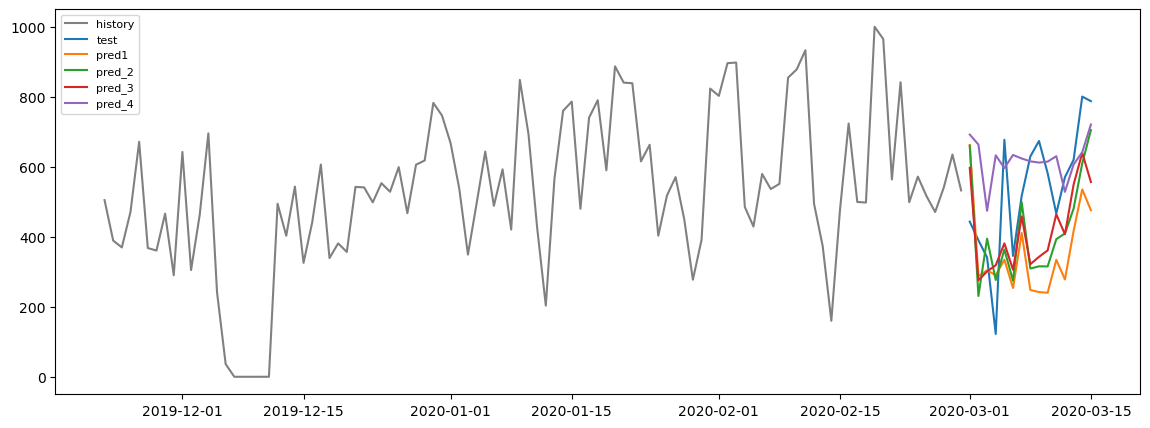

In [61]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
plt.plot(train[-100:], label='history', color='grey')
plt.plot(test, label='test')
plt.plot(pred_1, label='pred1')
plt.plot(pred_2, label='pred_2')
plt.plot(pred_3, label='pred_3')
plt.plot(pred_4, label='pred_4')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [62]:
import sklearn.metrics as skmetrics #For evaluation metrics
r1 = np.sqrt(skmetrics.mean_squared_error(test, pred_1))
r2 = np.sqrt(skmetrics.mean_squared_error(test, pred_2))
r3 = np.sqrt(skmetrics.mean_squared_error(test, pred_3))
r4 = np.sqrt(skmetrics.mean_squared_error(test, pred_4))

In [63]:
r1,r2,r3,r4
# model3 = seasonal="add", seasonal_periods=365, damped_trend=False

(256.2167177634726, 199.67694277017173, 188.51111085287707, 196.48570226067864)

# Theta

In [64]:
train.head(3)
# theta method must use datetime index

,ActivePower
Datetime,
2018-01-01 00:00:00+00:00,366.223561
2018-01-02 00:00:00+00:00,462.550740
2018-01-03 00:00:00+00:00,454.417752


In [69]:
model_5 = ThetaModel(train)
res = model_5.fit()
pred5 = res.forecast(len(test))

model_6= ThetaModel(train, period=365)
res = model_6.fit()
pred6 = res.forecast(len(test))

model_7= ThetaModel(train, period=365, method="additive") # method is seanonality 
res = model_7.fit()
pred7 = res.forecast(len(test))

In [70]:
pred_5 = pd.DataFrame(pred5.values, index=test.index)
pred_6 = pd.DataFrame(pred6.values, index=test.index)
pred_7 = pd.DataFrame(pred7.values, index=test.index)

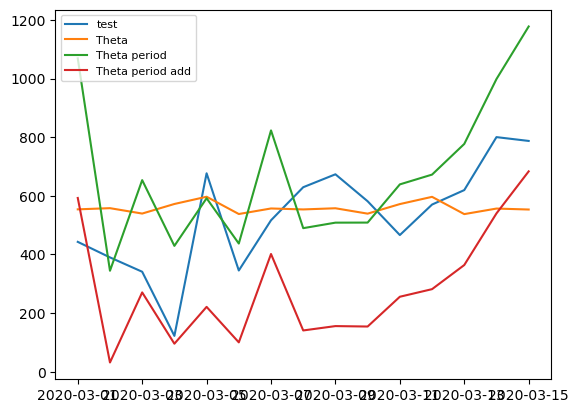

In [71]:
# plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred_5, label='Theta')
plt.plot(pred_6, label='Theta period')
plt.plot(pred_7, label='Theta period add')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [72]:
r5 = np.sqrt(skmetrics.mean_squared_error(test, pred_5))
r6 = np.sqrt(skmetrics.mean_squared_error(test, pred_6))
r7 = np.sqrt(skmetrics.mean_squared_error(test, pred_7))
r5,r6,r7

(179.08046791799424, 258.7170262036987, 305.29181753931414)